In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader
import pandas as pd
import copy

In [26]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/finetuning', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import SequentialDeepONetDataset
from helper import load_model_experiment, convert2dim, fit, compute_metrics_region, plot_field_region
from forecasting_analysis import create_windows_forecasting_with_index
from finetune import create_contiguous_adaptation_set, create_eval_set_after_contiguous_adaptation, freeze_for_new_station_adaptation, expand_lstm_input_dim_correct, mask_new_station, fine_tune_adapt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [27]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make CuDNN deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Extra reproducibility for dataloaders
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(1234)

## Load Datasets

In [28]:
# original input sensor data: neutron monitor data 
input_sensor = np.load('data/neutron_data_22yrs.npy')

# new sensor data: MXCO
mxco_sensor = np.load('data/add_sensor/neutron_data_MXCO.npy').reshape(-1, 1)

# add new sensor data as additional channel
input_sensor = np.concatenate((input_sensor, mxco_sensor), axis=1)

# output dose data
output = np.load('data/dose_array.npy')

# location
trunk = np.load('data/grid_points.npy')

print('location range (1 deg):', np.min(trunk[:,0]), np.max(trunk[:,0]), np.min(trunk[:,1]), np.max(trunk[:,1]))

# Normalize trunk input
trunk[:, 0] = (trunk[:, 0] - np.min(trunk[:, 0])) / (np.max(trunk[:, 0]) - np.min(trunk[:, 0]))
trunk[:, 1] = (trunk[:, 1] - np.min(trunk[:, 1])) / (np.max(trunk[:, 1]) - np.min(trunk[:, 1]))

location range (1 deg): -90.0 90.0 -180.0 180.0


In [29]:
dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = 30, 0
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_sensor, output, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7641, 30, 13]) torch.Size([7641, 65341])
Validation set: torch.Size([365, 30, 13]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 13]) torch.Size([365, 65341])


In [30]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_input.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)[..., np.newaxis]
y_val_scaled   = scaler_target.transform(y_val)[..., np.newaxis]
y_test_scaled  = scaler_target.transform(y_test)[..., np.newaxis]

In [31]:
# Choose realistic commissioning windows (first X days of 2023)
days_7  = 7
days_14 = 14
days_30 = 30

# --- Adaptation loaders (first X days) ---
adapt_loader_7d,  idx_7d  = create_contiguous_adaptation_set(
    X_test_scaled, y_test_scaled, trunk, num_days=days_7, batch_size=32
)
adapt_loader_14d, idx_14d = create_contiguous_adaptation_set(
    X_test_scaled, y_test_scaled, trunk, num_days=days_14, batch_size=32
)
adapt_loader_30d, idx_30d = create_contiguous_adaptation_set(
    X_test_scaled, y_test_scaled, trunk, num_days=days_30, batch_size=32
)

# --- Evaluation loaders (remaining days after adaptation window) ---
eval_loader_7d,  eval_idx_7d  = create_eval_set_after_contiguous_adaptation(
    X_test_scaled, y_test_scaled, trunk, idx_7d, batch_size=32
)
eval_loader_14d, eval_idx_14d = create_eval_set_after_contiguous_adaptation(
    X_test_scaled, y_test_scaled, trunk, idx_14d, batch_size=32
)
eval_loader_30d, eval_idx_30d = create_eval_set_after_contiguous_adaptation(
    X_test_scaled, y_test_scaled, trunk, idx_30d, batch_size=32
)


## Model

In [32]:
# 1. Load the original pretrained model (12 sensors)
pre_trained_model = load_model_experiment(
    'analysis/baseline/single_branch/lstm_window_30.pth'
)

# 2. Expand the LSTM input layer from 12 → 13 channels
old_lstm = pre_trained_model.branch_net.lstm

new_lstm = expand_lstm_input_dim_correct(old_lstm, add_inputs=1)
pre_trained_model.branch_net.lstm = new_lstm


Loaded model from analysis/baseline/single_branch/lstm_window_30.pth


### 7 Days

In [33]:
freeze_for_new_station_adaptation(pre_trained_model)

# 7-day adaptation window
adapt_loader_7d, idx_7d = create_contiguous_adaptation_set(
    X_test_scaled, y_test_scaled, trunk, num_days=7
)

eval_loader_7d, eval_idx_7d = create_eval_set_after_contiguous_adaptation(
    X_test_scaled, y_test_scaled, trunk, idx_7d
)

optimizer = torch.optim.AdamW(
    (p for p in pre_trained_model.parameters() if p.requires_grad),
    lr=1e-4,
    weight_decay=1e-4
)

fine_tune_adapt(
    pre_trained_model,
    adapt_loader_7d,
    optimizer,
    num_epochs=12,
    device="cuda"
)

# Evaluate Mode A (13-sensor adapted model with MXCO data used)
pred_a_7d, target_7d = fit(
    pre_trained_model,
    eval_loader_7d,
    device,
    scaler_target,
    mask_new=False   # MXCO is used
)


# Evaluate Mode B (12-sensor masked adapted)
pred_b_7d, _ = fit(
    pre_trained_model,
    eval_loader_7d,
    device,
    scaler_target,
    mask_new=True
)

# Evaluate Mode C (13-sensor expanded but NOT adapted)
base_expanded_model = load_model_experiment(
    'analysis/baseline/single_branch/lstm_window_30.pth'
)
old_lstm2 = base_expanded_model.branch_net.lstm
base_expanded_model.branch_net.lstm = expand_lstm_input_dim_correct(
    old_lstm2, add_inputs=1
)

pred_c_7d, _ = fit(
    base_expanded_model,
    eval_loader_7d,
    device,
    scaler_target,
    mask_new=False
)


# predictions to 2D grid
lon_grid, lat_grid, pred_a_7d_grid = convert2dim(pred_a_7d)
_, _, pred_b_7d_grid = convert2dim(pred_b_7d)
_, _, pred_c_7d_grid = convert2dim(pred_c_7d)

# target to 2D grid
_, _, target_7d_grid = convert2dim(target_7d)

# set evaluation region
region_extent_world = [-180, 180, -90, 90]
region_extent_selected = [-140, -40, 0, 60]

print('-- region: world --')
l2_a_7d, ssim_a_7d = compute_metrics_region(pred_a_7d_grid, target_7d_grid, lon_grid, lat_grid, region_extent_world)
l2_b_7d, ssim_b_7d = compute_metrics_region(pred_b_7d_grid, target_7d_grid, lon_grid, lat_grid, region_extent_world)
l2_c_7d, ssim_c_7d = compute_metrics_region(pred_c_7d_grid, target_7d_grid, lon_grid, lat_grid, region_extent_world)

print('-- region: selected --')
l2_a_7d_sel, ssim_a_7d_sel = compute_metrics_region(pred_a_7d_grid, target_7d_grid, lon_grid, lat_grid, region_extent_selected)
l2_b_7d_sel, ssim_b_7d_sel = compute_metrics_region(pred_b_7d_grid, target_7d_grid, lon_grid, lat_grid, region_extent_selected)
l2_c_7d_sel, ssim_c_7d_sel = compute_metrics_region(pred_c_7d_grid, target_7d_grid, lon_grid, lat_grid, region_extent_selected)

Epoch 1/12: 100%|██████████| 1/1 [00:00<00:00, 81.43it/s]


Epoch 1: avg adaptation loss = 0.002607


Epoch 2/12: 100%|██████████| 1/1 [00:00<00:00, 84.97it/s]


Epoch 2: avg adaptation loss = 0.001713


Epoch 3/12: 100%|██████████| 1/1 [00:00<00:00, 85.84it/s]


Epoch 3: avg adaptation loss = 0.001014


Epoch 4/12: 100%|██████████| 1/1 [00:00<00:00, 85.95it/s]


Epoch 4: avg adaptation loss = 0.000513


Epoch 5/12: 100%|██████████| 1/1 [00:00<00:00, 87.19it/s]


Epoch 5: avg adaptation loss = 0.000199


Epoch 6/12: 100%|██████████| 1/1 [00:00<00:00, 86.34it/s]


Epoch 6: avg adaptation loss = 0.000054


Epoch 7/12: 100%|██████████| 1/1 [00:00<00:00, 87.01it/s]


Epoch 7: avg adaptation loss = 0.000043


Epoch 8/12: 100%|██████████| 1/1 [00:00<00:00, 86.93it/s]


Epoch 8: avg adaptation loss = 0.000122


Epoch 9/12: 100%|██████████| 1/1 [00:00<00:00, 87.28it/s]


Epoch 9: avg adaptation loss = 0.000237


Epoch 10/12: 100%|██████████| 1/1 [00:00<00:00, 86.59it/s]


Epoch 10: avg adaptation loss = 0.000344


Epoch 11/12: 100%|██████████| 1/1 [00:00<00:00, 71.35it/s]


Epoch 11: avg adaptation loss = 0.000413


Epoch 12/12: 100%|██████████| 1/1 [00:00<00:00, 86.52it/s]


Epoch 12: avg adaptation loss = 0.000431
Loaded model from analysis/baseline/single_branch/lstm_window_30.pth
-- region: world --
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.3052577358195539
Mean SSIM: 0.9993728599988321
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.3078640572792767
Mean SSIM: 0.9993676114323174
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 1.3726973422414683
Mean SSIM: 0.9989539588034564
-- region: selected --
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 0.3140118340337103
Mean SSIM: 0.9983563181090166
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 0.31390238929576275
Mean SSIM: 0.998346089746681
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 1.4234857121731943
Mean SSIM: 0.9976477147939755


### 14 Days

In [34]:
freeze_for_new_station_adaptation(pre_trained_model)

# 7-day adaptation window
adapt_loader_14d, idx_14d = create_contiguous_adaptation_set(
    X_test_scaled, y_test_scaled, trunk, num_days=14
)

eval_loader_14d, eval_idx_14d = create_eval_set_after_contiguous_adaptation(
    X_test_scaled, y_test_scaled, trunk, idx_14d
)

optimizer = torch.optim.AdamW(
    (p for p in pre_trained_model.parameters() if p.requires_grad),
    lr=1e-4,
    weight_decay=1e-4
)

fine_tune_adapt(
    pre_trained_model,
    adapt_loader_14d,
    optimizer,
    num_epochs=8,
    device="cuda"
)

# Evaluate Mode A (13-sensor adapted model with MXCO data used)
pred_a_14d, target_14d = fit(
    pre_trained_model,
    eval_loader_14d,
    device,
    scaler_target,
    mask_new=False   # MXCO is used
)


# Evaluate Mode B (12-sensor masked adapted)
pred_b_14d, _ = fit(
    pre_trained_model,
    eval_loader_14d,
    device,
    scaler_target,
    mask_new=True
)

# Evaluate Mode C (13-sensor expanded but NOT adapted)
base_expanded_model = load_model_experiment(
    'analysis/baseline/single_branch/lstm_window_30.pth'
)
old_lstm2 = base_expanded_model.branch_net.lstm
base_expanded_model.branch_net.lstm = expand_lstm_input_dim_correct(
    old_lstm2, add_inputs=1
)

pred_c_14d, _ = fit(
    base_expanded_model,
    eval_loader_14d,
    device,
    scaler_target,
    mask_new=False
)


# predictions to 2D grid
lon_grid, lat_grid, pred_a_14d_grid = convert2dim(pred_a_14d)
_, _, pred_b_14d_grid = convert2dim(pred_b_14d)
_, _, pred_c_14d_grid = convert2dim(pred_c_14d)

# target to 2D grid
_, _, target_14d_grid = convert2dim(target_14d)

# set evaluation region
region_extent_world = [-180, 180, -90, 90]
region_extent_selected = [-140, -40, 0, 60]

print('-- region: world --')
l2_a_14d, ssim_a_14d = compute_metrics_region(pred_a_14d_grid, target_14d_grid, lon_grid, lat_grid, region_extent_world)
l2_b_14d, ssim_b_14d = compute_metrics_region(pred_b_14d_grid, target_14d_grid, lon_grid, lat_grid, region_extent_world)
l2_c_14d, ssim_c_14d = compute_metrics_region(pred_c_14d_grid, target_14d_grid, lon_grid, lat_grid, region_extent_world)

print('-- region: selected --')
l2_a_14d_sel, ssim_a_14d_sel = compute_metrics_region(pred_a_14d_grid, target_14d_grid, lon_grid, lat_grid, region_extent_selected)
l2_b_14d_sel, ssim_b_14d_sel = compute_metrics_region(pred_b_14d_grid, target_14d_grid, lon_grid, lat_grid, region_extent_selected)
l2_c_14d_sel, ssim_c_14d_sel = compute_metrics_region(pred_c_14d_grid, target_14d_grid, lon_grid, lat_grid, region_extent_selected)

Epoch 1/8: 100%|██████████| 1/1 [00:00<00:00, 45.84it/s]


Epoch 1: avg adaptation loss = 0.000372


Epoch 2/8: 100%|██████████| 1/1 [00:00<00:00, 47.70it/s]


Epoch 2: avg adaptation loss = 0.000100


Epoch 3/8: 100%|██████████| 1/1 [00:00<00:00, 47.95it/s]


Epoch 3: avg adaptation loss = 0.000021


Epoch 4/8: 100%|██████████| 1/1 [00:00<00:00, 47.86it/s]


Epoch 4: avg adaptation loss = 0.000071


Epoch 5/8: 100%|██████████| 1/1 [00:00<00:00, 45.35it/s]


Epoch 5: avg adaptation loss = 0.000133


Epoch 6/8: 100%|██████████| 1/1 [00:00<00:00, 48.31it/s]


Epoch 6: avg adaptation loss = 0.000140


Epoch 7/8: 100%|██████████| 1/1 [00:00<00:00, 48.45it/s]


Epoch 7: avg adaptation loss = 0.000103


Epoch 8/8: 100%|██████████| 1/1 [00:00<00:00, 57.48it/s]


Epoch 8: avg adaptation loss = 0.000056
Loaded model from analysis/baseline/single_branch/lstm_window_30.pth
-- region: world --
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.6505483646098513
Mean SSIM: 0.9992786296426207
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.688446314850906
Mean SSIM: 0.999263472961203
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.2051776614382557
Mean SSIM: 0.9980812775607169
-- region: selected --
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 0.68934267627614
Mean SSIM: 0.9980879404114171
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 0.7249215608610337
Mean SSIM: 0.9980572680767866
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 2.297169561696976
Mean SSIM: 0.9958346560454627


### 30 Days

In [35]:
# 30-day adaptation window (replace the 14-day block)
freeze_for_new_station_adaptation(pre_trained_model)

# 30-day adaptation set
adapt_loader_30d, idx_30d = create_contiguous_adaptation_set(
    X_test_scaled, y_test_scaled, trunk, num_days=30
)

# evaluation set after adaptation window
eval_loader_30d, eval_idx_30d = create_eval_set_after_contiguous_adaptation(
    X_test_scaled, y_test_scaled, trunk, idx_30d
)

optimizer = torch.optim.AdamW(
    (p for p in pre_trained_model.parameters() if p.requires_grad),
    lr=1e-4,
    weight_decay=1e-4
)

# fine-tune on the 30-day adaptation window
fine_tune_adapt(
    pre_trained_model,
    adapt_loader_30d,
    optimizer,
    num_epochs=8,
    device="cuda"
)

# Evaluate Mode A (13-sensor adapted model with MXCO data used)
pred_a_30d, target_30d = fit(
    pre_trained_model,
    eval_loader_30d,
    device,
    scaler_target,
    mask_new=False   # MXCO is used
)

# Evaluate Mode B (12-sensor masked adapted)
pred_b_30d, _ = fit(
    pre_trained_model,
    eval_loader_30d,
    device,
    scaler_target,
    mask_new=True
)

# Evaluate Mode C (13-sensor expanded but NOT adapted)
base_expanded_model = load_model_experiment(
    'analysis/baseline/single_branch/lstm_window_30.pth'
)
old_lstm2 = base_expanded_model.branch_net.lstm
base_expanded_model.branch_net.lstm = expand_lstm_input_dim_correct(
    old_lstm2, add_inputs=1
)

pred_c_30d, _ = fit(
    base_expanded_model,
    eval_loader_30d,
    device,
    scaler_target,
    mask_new=False
)


# predictions to 2D grid
lon_grid, lat_grid, pred_a_30d_grid = convert2dim(pred_a_30d)
_, _, pred_b_30d_grid = convert2dim(pred_b_30d)
_, _, pred_c_30d_grid = convert2dim(pred_c_30d)

# target to 2D grid
_, _, target_30d_grid = convert2dim(target_30d)

# set evaluation region(s)
region_extent_world = [-180, 180, -90, 90]
region_extent_selected = [-140, -40, 0, 60]

print('-- region: world --')
l2_a_30d, ssim_a_30d = compute_metrics_region(pred_a_30d_grid, target_30d_grid, lon_grid, lat_grid, region_extent_world)
l2_b_30d, ssim_b_30d = compute_metrics_region(pred_b_30d_grid, target_30d_grid, lon_grid, lat_grid, region_extent_world)
l2_c_30d, ssim_c_30d = compute_metrics_region(pred_c_30d_grid, target_30d_grid, lon_grid, lat_grid, region_extent_world)

print('-- region: selected --')
l2_a_30d_sel, ssim_a_30d_sel = compute_metrics_region(pred_a_30d_grid, target_30d_grid, lon_grid, lat_grid, region_extent_selected)
l2_b_30d_sel, ssim_b_30d_sel = compute_metrics_region(pred_b_30d_grid, target_30d_grid, lon_grid, lat_grid, region_extent_selected)
l2_c_30d_sel, ssim_c_30d_sel = compute_metrics_region(pred_c_30d_grid, target_30d_grid, lon_grid, lat_grid, region_extent_selected)

Epoch 1/8:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/8: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


Epoch 1: avg adaptation loss = 0.000073


Epoch 2/8: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


Epoch 2: avg adaptation loss = 0.000058


Epoch 3/8: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


Epoch 3: avg adaptation loss = 0.000066


Epoch 4/8: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]


Epoch 4: avg adaptation loss = 0.000044


Epoch 5/8: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


Epoch 5: avg adaptation loss = 0.000043


Epoch 6/8: 100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


Epoch 6: avg adaptation loss = 0.000054


Epoch 7/8: 100%|██████████| 1/1 [00:00<00:00, 25.81it/s]


Epoch 7: avg adaptation loss = 0.000050


Epoch 8/8: 100%|██████████| 1/1 [00:00<00:00, 28.27it/s]


Epoch 8: avg adaptation loss = 0.000040
Loaded model from analysis/baseline/single_branch/lstm_window_30.pth
-- region: world --
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.47104149968598574
Mean SSIM: 0.9993239313209737
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.5063381484592734
Mean SSIM: 0.9993116503866499
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.8387921299154013
Mean SSIM: 0.9972187668654307
-- region: selected --
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 0.4977527951631999
Mean SSIM: 0.998192008212554
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 0.5311023352331236
Mean SSIM: 0.9981666981021855
Region [-140, -40, 0, 60]
Mean rel-L2 (%): 2.693279870216949
Mean SSIM: 0.9951278915306658


## Visualization

In [46]:
windows = ["7 days", "14 days", "30 days"]

means_A = [
    l2_a_7d_sel.mean(),
    l2_a_14d_sel.mean(),
    l2_a_30d_sel.mean()
]

stds_A = [
    l2_a_7d_sel.std(),
    l2_a_14d_sel.std(),
    l2_a_30d_sel.std()
]

means_B = [
    l2_b_7d_sel.mean(),
    l2_b_14d_sel.mean(),
    l2_b_30d_sel.mean()
]

stds_B = [
    l2_b_7d_sel.std(),
    l2_b_14d_sel.std(),
    l2_b_30d_sel.std()
]

means_C = [
    l2_c_7d_sel.mean(),
    l2_c_14d_sel.mean(),
    l2_c_30d_sel.mean()
]

stds_C = [
    l2_c_7d_sel.std(),
    l2_c_14d_sel.std(),
    l2_c_30d_sel.std()
]


In [36]:
target_date = pd.date_range("2023-01-01", "2023-12-31", freq="D")

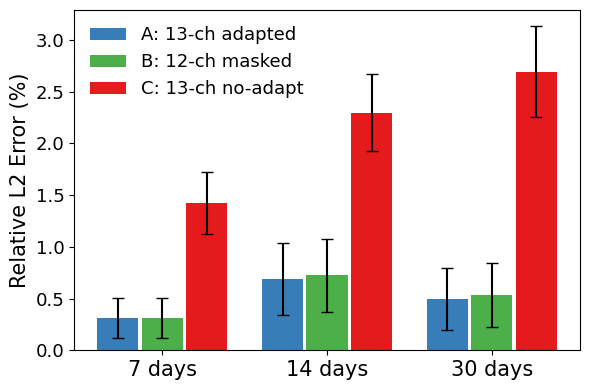

In [ ]:
x = np.arange(len(windows))

width = 0.25
inner_gap = 0.02   # spacing inside the window

pos_A = x - (width + inner_gap)
pos_B = x
pos_C = x + (width + inner_gap)

plt.figure(figsize=(6,4))

# Use the same color semantics as Fig. 5:
# Blue = Model A, Green = Model B, Red = Model C
plt.bar(
    pos_A, means_A, width, yerr=stds_A, capsize=4,
    label="A: 13-ch adapted", color="#377eb8"   # blue
)

plt.bar(
    pos_B, means_B, width, yerr=stds_B, capsize=4,
    label="B: 12-ch masked", color="#4daf4a"    # green
)

plt.bar(
    pos_C, means_C, width, yerr=stds_C, capsize=4,
    label="C: 13-ch no-adapt", color="#e41a1c"   # red
)

plt.xticks(x, windows, fontsize=15)
plt.yticks(fontsize=13)
plt.ylabel("Relative L2 Error (%)", fontsize=15)
plt.legend(frameon=False, fontsize=13)

plt.tight_layout()
#plt.savefig('analysis/finetuning/figures/new_sensor_finetune_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


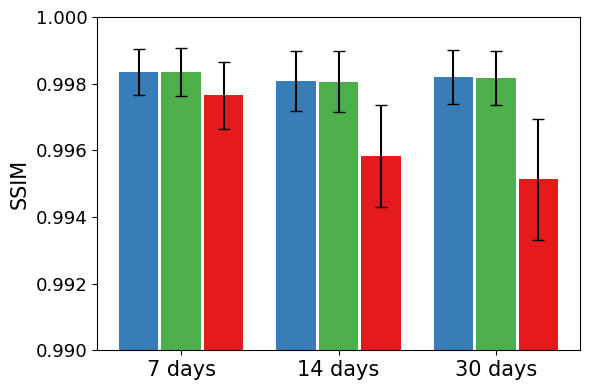

In [ ]:
# Compute mean/std SSIM for each window and mode
means_A_ssim = [
    ssim_a_7d_sel.mean(),
    ssim_a_14d_sel.mean(),
    ssim_a_30d_sel.mean()
]
stds_A_ssim = [
    ssim_a_7d_sel.std(),
    ssim_a_14d_sel.std(),
    ssim_a_30d_sel.std()
]

means_B_ssim = [
    ssim_b_7d_sel.mean(),
    ssim_b_14d_sel.mean(),
    ssim_b_30d_sel.mean()
]
stds_B_ssim = [
    ssim_b_7d_sel.std(),
    ssim_b_14d_sel.std(),
    ssim_b_30d_sel.std()
]

means_C_ssim = [
    ssim_c_7d_sel.mean(),
    ssim_c_14d_sel.mean(),
    ssim_c_30d_sel.mean()
]
stds_C_ssim = [
    ssim_c_7d_sel.std(),
    ssim_c_14d_sel.std(),
    ssim_c_30d_sel.std()
]

# Bar geometry matches your L2 plot
width = 0.25
inner_gap = 0.02

pos_A = x - (width + inner_gap)
pos_B = x
pos_C = x + (width + inner_gap)

plt.figure(figsize=(6,4))

plt.bar(
    pos_A, means_A_ssim, width, yerr=stds_A_ssim, capsize=4,
    label="A: 13-ch adapted", color="#377eb8"
)
plt.bar(
    pos_B, means_B_ssim, width, yerr=stds_B_ssim, capsize=4,
    label="B: 12-ch masked", color="#4daf4a"
)
plt.bar(
    pos_C, means_C_ssim, width, yerr=stds_C_ssim, capsize=4,
    label="C: 13-ch no-adapt", color="#e41a1c"
)

plt.xticks(x, windows, fontsize=15)
plt.yticks(fontsize=13)
plt.ylabel("SSIM", fontsize=15)
plt.ylim(0.99, 1.0)  # tighten for readability, adjust if needed

#plt.legend(frameon=False, fontsize=13)
plt.tight_layout()

#plt.savefig("analysis/finetuning/figures/new_sensor_finetune_comparison_ssim.png",dpi=300, bbox_inches="tight")
plt.show()
